In [1]:
# Francisco Dominguez Mateos
# 04/07/2020
# from: https://github.com/google/jax/pull/1196/commits/d9ee85274c5b75054a3aad1f44b28e08f685ac70
#       https://github.com/google/jax/pull/1196

In [2]:
#!conda install -c pytorch pytorch --yes
#!conda install -c pytorch torchvision --yes
#!conda install -c anaconda seaborn --yes

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random

from jax.nn import sigmoid
from jax.nn.initializers import glorot_normal, normal

from functools import partial
from jax import lax

from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax)

In [5]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers

import torch
from torchvision import datasets, transforms

import time
#from: https://github.com/RobertTLange/code-and-blog/blob/master/04_jax_intro/helpers.py
#!conda install -c anaconda seaborn --yes
from helpers import plot_mnist_examples

In [6]:
# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

(50, 100) (50, 100)


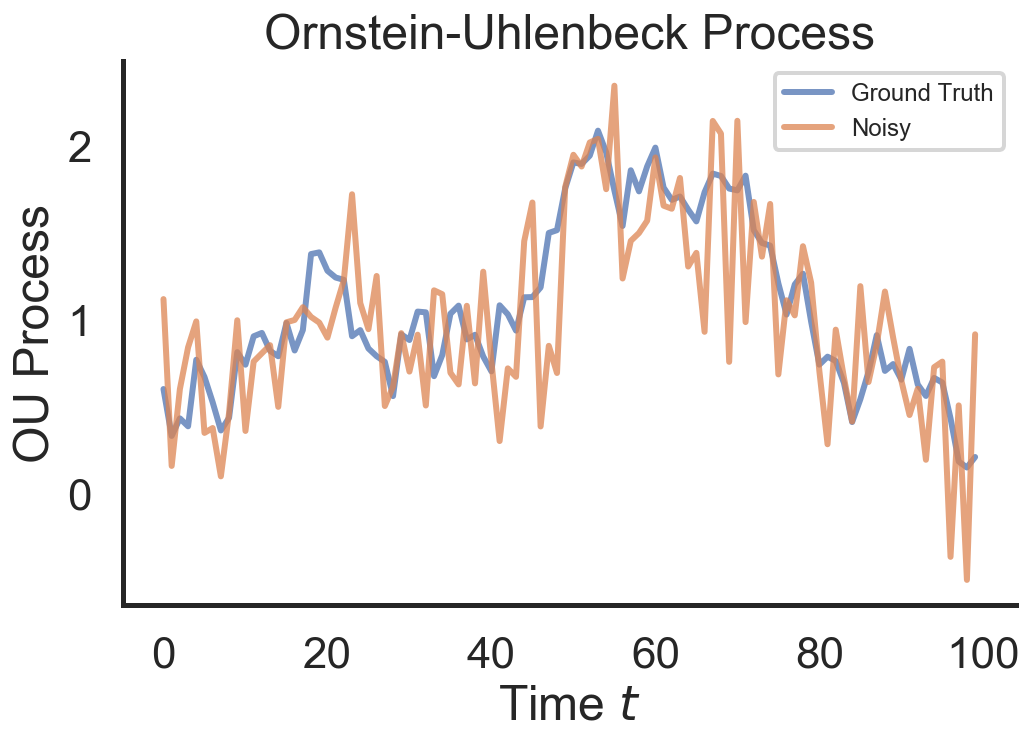

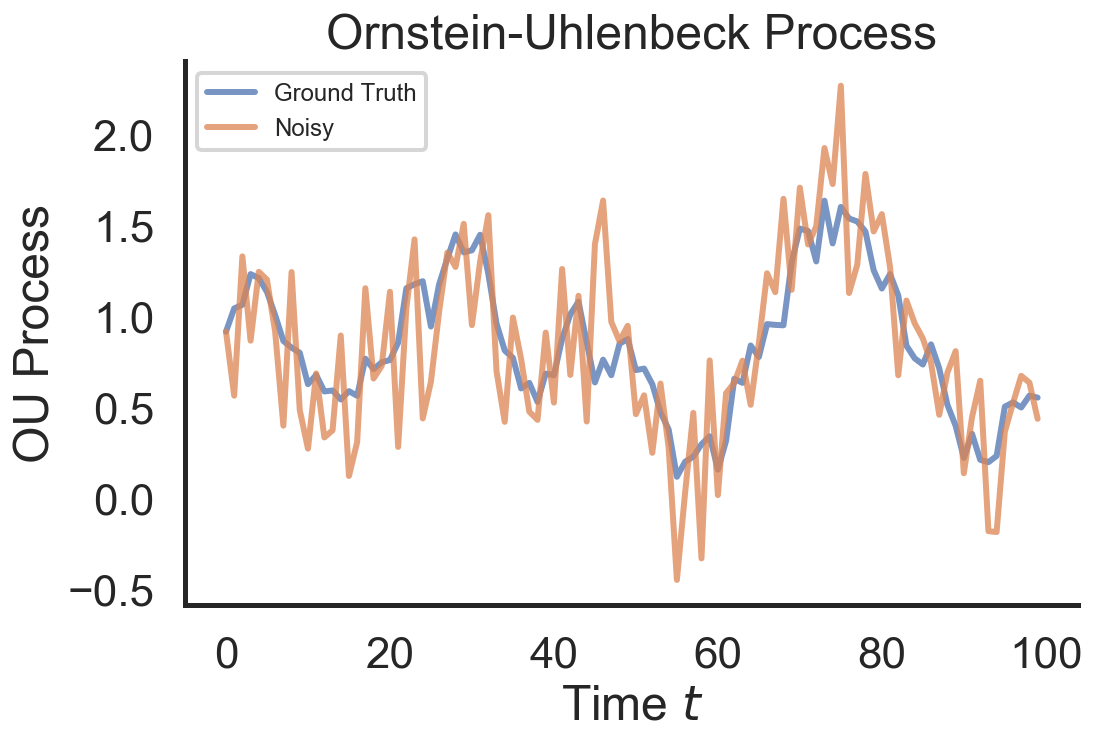

In [7]:
# Generate & plot a time series generated by the OU process
from helpers import generate_ou_process, plot_ou_process
x_0, mu, tau, sigma, dt = 0, 1, 2, 0.5, 0.1
noise_std = 0.1
num_dims, batch_size = 100, 50  # Number of timesteps in process

x, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau,
                                 sigma, noise_std, dt)
print(x.shape,x_tilde.shape)
plot_ou_process(x[ 0, :], x_tilde[ 0, :])
plot_ou_process(x[49, :], x_tilde[49, :])

In [18]:
def LSTM(out_dim, W_init = glorot_normal(), b_init = normal()):
  def init_fun(rng, input_shape):
    in_dim=input_shape[-1]
    k1, k2 = random.split(rng)
    cell, hidden = b_init(k1, (out_dim,)), b_init(k2, (out_dim,)) 

    k1, k2, k3 = random.split(k1, num=3)
    forget_W = W_init(k1, (in_dim, out_dim))
    forget_U = W_init(k2, (out_dim, out_dim))
    forget_b = b_init(k3, (out_dim,)) 

    k1, k2, k3 = random.split(k1, num=3)
    in_W = W_init(k1, (in_dim, out_dim))
    in_U = W_init(k2, (out_dim, out_dim))
    in_b = b_init(k3, (out_dim,)) 

    k1, k2, k3 = random.split(k1, num=3)
    out_W = W_init(k1, (in_dim, out_dim))
    out_U = W_init(k2, (out_dim, out_dim))
    out_b = b_init(k3, (out_dim,)) 

    k1, k2, k3 = random.split(k1, num=3)    
    change_W = W_init(k1, (in_dim, out_dim)) 
    change_U = W_init(k2, (out_dim, out_dim))
    change_b = b_init(k3, (out_dim,)) 

    output_shape =  input_shape[:-1] + (out_dim,)
    return output_shape, ((cell, hidden), (forget_W, forget_U, forget_b), (in_W, in_U, in_b),
                           (out_W, out_U, out_b), (change_W, change_U, change_b))

  def apply_fun_scan(params, h, inputs):
    old_cell, hidden = h
    """ Perform single step update of the network """
    _, (forget_W, forget_U, forget_b), (in_W, in_U, in_b), (out_W, out_U, out_b), (
        change_W, change_U, change_b) = params
    input_gate  = sigmoid(np.dot(inputs, in_W    ) + np.dot(hidden, in_U    ) + in_b)
    forget_gate = sigmoid(np.dot(inputs, forget_W) + np.dot(hidden, forget_U) + forget_b)
    output_gate = sigmoid(np.dot(inputs, out_W   ) + np.dot(hidden, out_U   ) + out_b)
    change_gate = np.tanh(np.dot(inputs, change_W) + np.dot(hidden, change_U) + change_b)

    cell = np.multiply(change_gate, input_gate) + np.multiply(old_cell, forget_gate) 

    #this is hidden output
    output = np.multiply(output_gate, np.tanh(cell))

    return (output, cell), output
        
  def apply_fun(params, inputs, **kwargs):
    h = params[0]

    # Move the time dimension to position 0
    inputs = np.moveaxis(inputs, 1, 0)
    f = partial(apply_fun_scan, params)
    _, h_new = lax.scan(f, h, inputs)
    print(inputs.shape)
    print(h_new.shape)
    return h_new

  return init_fun, apply_fun

In [24]:
def GRU(out_dim, W_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        """ Initialize the GRU layer for stax """
        hidden = b_init(rng, (input_shape[0], out_dim))

        k1, k2, k3 = random.split(rng, num=3)
        update_W, update_U, update_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        reset_W, reset_U, reset_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        out_W, out_U, out_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)
        # Input dim 0 represents the batch dimension
        # Input dim 1 represents the time dimension (before scan moveaxis)
        output_shape = (input_shape[0], input_shape[1], out_dim)
        return (output_shape,
            (hidden,
             (update_W, update_U, update_b),
             (reset_W, reset_U, reset_b),
             (out_W, out_U, out_b),),)

    def apply_fun(params, inputs, **kwargs):
        """ Loop over the time steps of the input sequence """
        # first parameter is hidden look up at init_fun
        h = params[0]

        def apply_fun_scan(params, hidden, inp):
            """ Perform single step update of the network """
            _, (update_W, update_U, update_b), (reset_W, reset_U, reset_b), (
                out_W, out_U, out_b) = params

            update_gate = sigmoid(np.dot(inp, update_W) +
                                  np.dot(hidden, update_U) + update_b)
            reset_gate = sigmoid(np.dot(inp, reset_W) +
                                 np.dot(hidden, reset_U) + reset_b)
            output_gate = np.tanh(np.dot(inp, out_W)
                                  + np.dot(np.multiply(reset_gate, hidden), out_U)
                                  + out_b)
            output = np.multiply(update_gate, hidden) + np.multiply(1-update_gate, output_gate)
            hidden = output
            return hidden, hidden

        # Move the time dimension to position 0
        inputs = np.moveaxis(inputs, 1, 0)
        f = partial(apply_fun_scan, params)
        _, h_new = lax.scan(f, h, inputs)
        print(inputs.shape)
        print(h_new.shape)
        return h_new

    return init_fun, apply_fun

In [19]:
num_dims = 100              # Number of OU timesteps
batch_size = 64            # Batchsize
num_hidden_units = 128      # GRU cells in the RNN layer

# Initialize the network and perform a forward pass
init_fun, gru_rnn = stax.serial(Dense(num_hidden_units), Relu,
                                LSTM(num_hidden_units), Dense(1))
_, params = init_fun(key, (batch_size, num_dims, 1))

In [20]:
def mse_loss(params, inputs, targets):
    """ Calculate the Mean Squared Error Prediction Loss. """
    preds = gru_rnn(params, inputs)
    print(inputs.shape,targets.shape,preds.shape)
    return np.mean((preds - targets)**2)

@jit
def update(params, x, y, opt_state):
    """ Perform a forward pass, calculate the MSE & perform a SGD step. """
    loss, grads = value_and_grad(mse_loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, loss

In [21]:
step_size = 1e-4
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)

In [22]:
num_batches = 1000

train_loss_log = []
start_time = time.time()
for batch_idx in range(num_batches):
    x, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std)
    x_in = np.expand_dims(x_tilde[:, :(num_dims-1)], 2)
    y = np.array(x[:, 1:])
    params, opt_state, loss = update(params, x_in, y, opt_state)
    batch_time = time.time() - start_time
    train_loss_log.append(loss)

    if batch_idx % 100 == 0:
        start_time = time.time()
        print("Batch {} | T: {:0.2f} | MSE: {:0.2f} |".format(batch_idx, batch_time, loss))

TypeError: scan carry output and input must have identical types, got
(ShapedArray(float32[64,128]), ShapedArray(float32[64,128]))
and
(ShapedArray(float32[128]), ShapedArray(float32[128])).

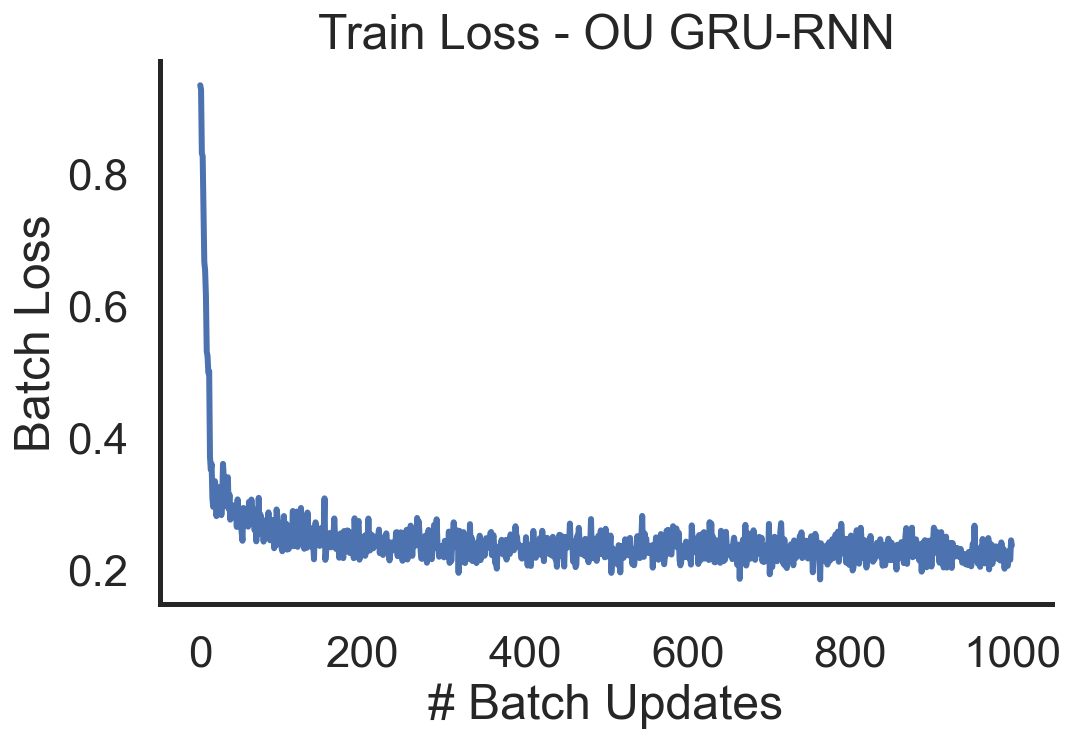

In [57]:
# Plot the training loss for OU-GRU-RNN!
from helpers import plot_ou_loss
plot_ou_loss(train_loss_log)

(99, 64, 128)
(99, 64, 128)


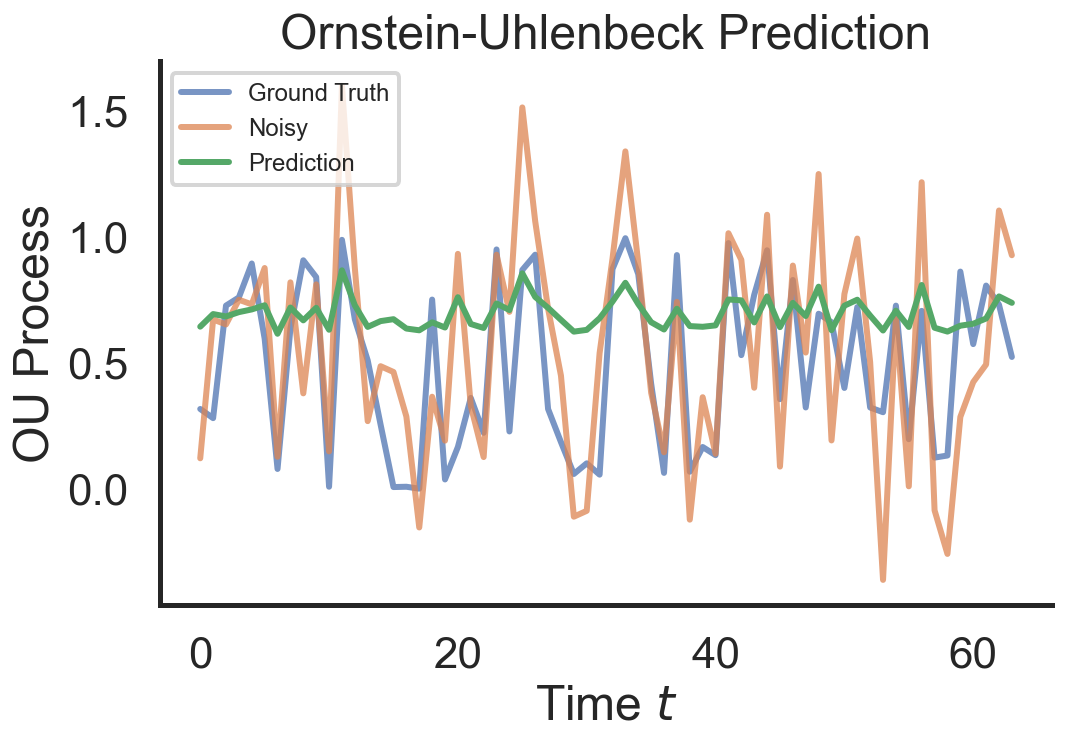

In [60]:
# Plot a prediction and ground truth OU process
x_true, x_tilde = generate_ou_process(batch_size, num_dims, mu, tau, sigma, noise_std)
x = np.expand_dims(x_tilde[:, :(num_dims-1)], 2)
y = np.array(x[:, 1:])
preds = gru_rnn(params, x)

x = onp.array(x)
y = onp.array(y)
x_pred = onp.array(preds)
plot_ou_process(x_true[:, 0], x_tilde=x_tilde[:, 0], x_pred=x_pred[0, :],
               title=r"Ornstein-Uhlenbeck Prediction")